# Module Installation

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Module

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import Dataset

In [ ]:
!gdown --id "18l4zolbPwMkmSDd--j1AbaLPeET0sWh-"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18l4zolbPwMkmSDd--j1AbaLPeET0sWh-
To: /content/Obligasi.csv
100% 3.55k/3.55k [00:00<00:00, 6.26MB/s]


In [ ]:
df = pd.read_csv('/content/Obligasi.csv', index_col=[0], parse_dates=True)
df = df.iloc[::-1]

In [ ]:
df.head()

,Pembukaan
Tanggal,
2005-01-01,9997
2005-02-01,10184
2005-03-01,10568
2005-04-01,11212
2005-05-01,11129


# EDA

## Visualisasi Dataset

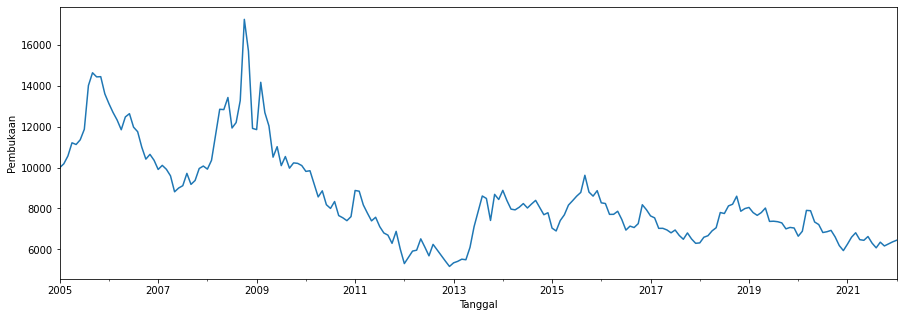

In [ ]:
df['Pembukaan'].plot(figsize=(15,5))
plt.ylabel('Pembukaan')
plt.show()

## Check Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

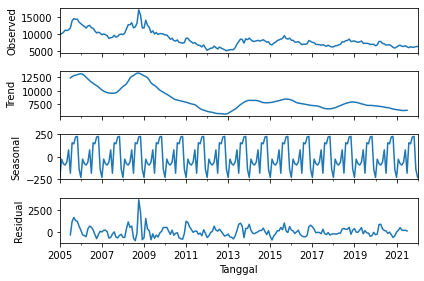

In [ ]:
decompose_result_mult = seasonal_decompose(df, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

Berdasarkan grafik tersebut dapat dilihat bahwa terdapat seasonality secara tahunan dimana nilai pembukaan obligasi akan sangat turun di pertengahan tahun dan akhir tahun

## Check Stationary

Menggunakan Augmented Dickey-Fuller Test dan Rolling Statistics Test

In [ ]:
dftest = adfuller(df['Pembukaan'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value

In [ ]:
dfoutput

Test Statistic                  -2.405470
p-value                          0.140198
#lags used                       6.000000
number of observations used    198.000000
critical value (1%)             -3.463815
critical value (5%)             -2.876251
critical value (10%)            -2.574611
dtype: float64

Berdasarkan data tersebut, dapat dilihat bahwa nilai dari test statistics lebih besar dibanding critical value. Oleh karena itu, null hypothesis diterima atau data tersebut stationary

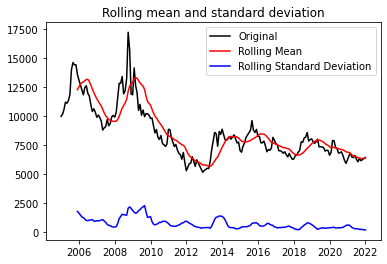

In [ ]:
rmean=df.rolling(window=12).mean()
rstd=df.rolling(window=12).std()

orig=plt.plot(df , color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

Nilai standar deviasi cukup stabil walau ada lonjakan di tahun 2009. Nilai dari mean antara t dan t-1 cukup berbeda secara signifikan sehingga data tidak stasioner.

## Check Autocorrelation

In [ ]:
prev_value = df.shift()
differenced_df = df - prev_value
differenced_df = differenced_df.dropna()

### Partial Autocorrelation

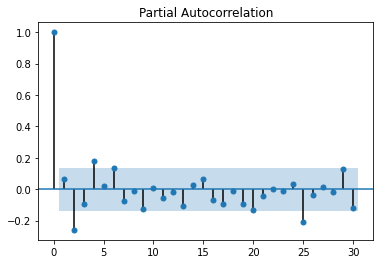

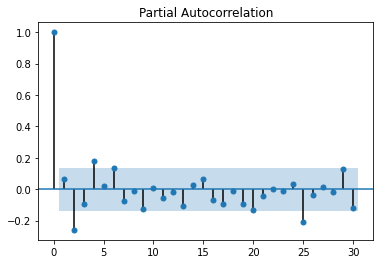

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(differenced_df, lags=30)

Berdasarkan grafik di atas dapat diketahui bahwa tidak ada nilai order yang berdampak signifikan untuk prediksi nilai saat ini


### Autocorrelation

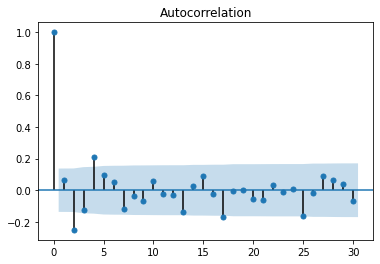

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(differenced_df, lags=30);

Berdasarkan grafik di atas dapat diketahui bahwa tidak ada nilai order yang berdampak signifikan untuk prediksi nilai saat ini.

# Preprocessing

## Check missing value

In [ ]:
df.isnull().sum()

Pembukaan    0
dtype: int64

## Transform to stationary

In [ ]:
prev_value = df.shift()
differenced_df = df - prev_value
differenced_df = differenced_df.dropna()

In [ ]:
dftest = adfuller(differenced_df['Pembukaan'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value

In [ ]:
dfoutput

Test Statistic                  -4.947245
p-value                          0.000028
#lags used                       5.000000
number of observations used    198.000000
critical value (1%)             -3.463815
critical value (5%)             -2.876251
critical value (10%)            -2.574611
dtype: float64

Test statistic lebih besar dari critical value, dataset sudah stationary

## Split Data

In [ ]:
def train_test_split(df):
  eighty_data = df.shape[0] * 0.8
  train_date_max = df.iloc[int(eighty_data)].name 
  train = df[df.index <= train_date_max]
  test = df[df.index >= train_date_max]
  return train, test

In [ ]:
train, test = train_test_split(differenced_df)

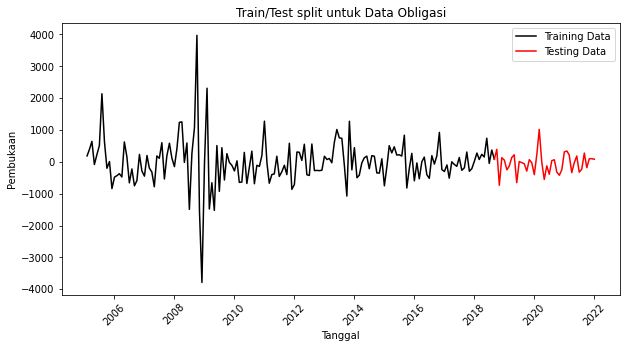

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train, color = "black", label="Training Data")
plt.plot(test, color = "red", label="Testing Data")
plt.ylabel('Pembukaan')
plt.xlabel('Tanggal')
plt.xticks(rotation=45)
plt.title("Train/Test split untuk Data Obligasi")
plt.legend()
plt.show()

# Model

## ARMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
train, test = train_test_split(differenced_df)
y = train['Pembukaan']

In [ ]:
model_ARMA = SARIMAX(y, order = (1, 0, 1))
model_ARMA = model_ARMA.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
y_pred = model_ARMA.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = model_ARMA.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

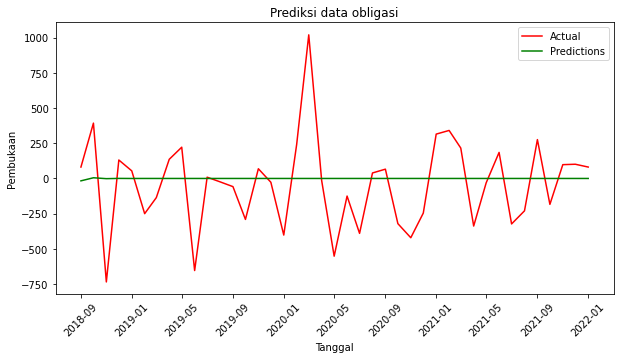

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(test['Pembukaan'], color = "red", label='Actual')
plt.ylabel('Pembukaan')
plt.xlabel('Tanggal')
plt.xticks(rotation=45)
plt.title("Prediksi data obligasi")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

arma_eval = mean_squared_error(test["Pembukaan"], y_pred_out)
print("MSE: ",arma_eval)

arma_eval = np.sqrt(mean_squared_error(test["Pembukaan"], y_pred_out))
print("RMSE: ",arma_eval)

MSE:  101809.15238107284
RMSE:  319.0754650252395


## ARIMA

In [ ]:
def train_test_split(df: pd.DataFrame, threshold: int):
  len_th = int(df.shape[0] * threshold)
  train = df.iloc[:len_th]
  test = df.iloc[len_th:]
  return train, test

In [ ]:
train, test = train_test_split(df_obligasi, 0.8)
print("train len", train.shape)
print("test len", test.shape)

train len (164, 1)
test len (41, 1)


Check seasonality for ARIMA Model

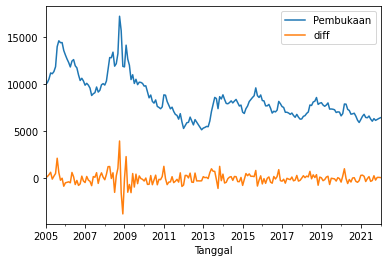

In [ ]:
df = df_obligasi.copy()
df_diff = df.diff()
df['diff'] = df_diff
df.plot()

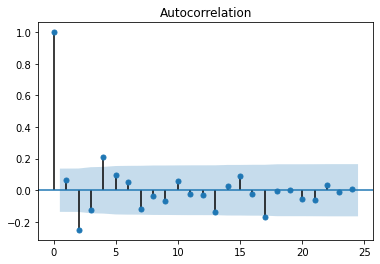

In [ ]:
df_diff = df_diff.fillna(0)
plot_acf(df_diff)
plt.show()


Seasonality not seen.

**ACF & PACF for MA size and lag order**

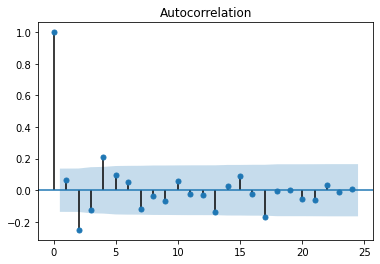

In [ ]:
plot_acf(df_diff)
plt.show()

Pick 1 for Average Rolling  
Pick 1 for first order differencing

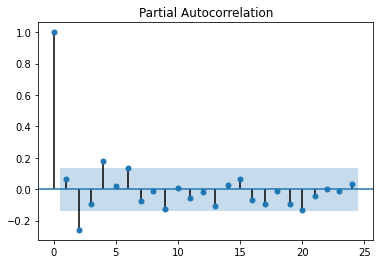

In [ ]:
plot_pacf(df_diff)
plt.show()

Pick 1 for Moving Average  
Order for ARIMA model = 1, 1, 1

Forecast monthly

### ARIMA untuk diff period = 0

In [ ]:
history_endog = train.copy()
index = pd.DatetimeIndex([], name='Tanggal')
y_true = pd.DataFrame([], columns=df_obligasi.columns, index=index)
y_pred = pd.DataFrame([], columns=df_obligasi.columns, index=index)
p, d, q = 1, 1, 1
model_fit = None

for idx in test.index: 
    model = ARIMA(endog=history_endog, order=(p,d,q))
    model_fit = model.fit()
    forecast = model_fit.forecast()[0][0]

    index = pd.DatetimeIndex([idx], name='Tanggal', freq='infer')
    obs = test.loc[idx].values[0] # observed value
    y_true = y_true.append(pd.DataFrame({'Pembukaan':obs}, index=index))
    y_pred = y_pred.append(pd.DataFrame({'Pembukaan':forecast}, index=index))
    history_endog = history_endog.append(pd.DataFrame({'Pembukaan':obs}, index=index))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

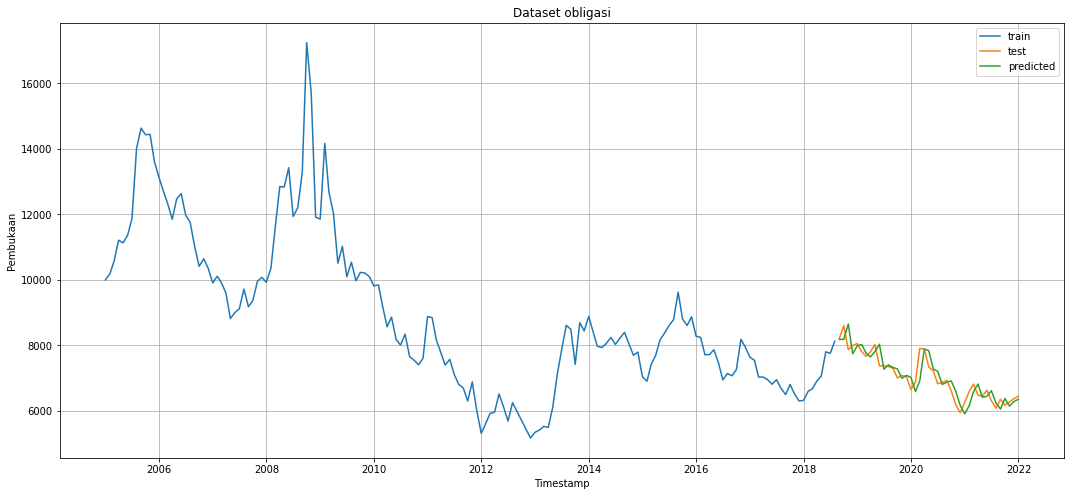

In [ ]:
fig = plt.figure(figsize=(18,8))
plt.plot(train, label='train')
plt.plot(y_true, label='test')
plt.plot(y_pred, label='predicted')
plt.xlabel("Timestamp")
plt.ylabel("Pembukaan")
plt.title("Dataset obligasi")
plt.legend()
plt.grid()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

mse = mean_squared_error(y_true["Pembukaan"], y_pred["Pembukaan"])
print(f"MSE: {mse}")

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

mape = mean_absolute_percentage_error(y_true["Pembukaan"], y_pred["Pembukaan"])
print(f"MAPE: {mape}")

MSE: 103661.0794796968
RMSE: 321.9644071628055
MAPE: 0.0346736624918791


### ARIMA untuk diff period = 1

In [ ]:
train, test = train_test_split(df_diff, 0.8)
print("train len", train.shape)
print("test len", test.shape)

train len (164, 1)
test len (41, 1)


In [ ]:
history_endog = train.copy()
index = pd.DatetimeIndex([], name='Tanggal')
y_true = pd.DataFrame([], columns=df_diff.columns, index=index)
y_pred = pd.DataFrame([], columns=df_diff.columns, index=index)
p, d, q = 1, 0, 1
model_fit = None

for idx in test.index: 
    model = ARIMA(endog=history_endog, order=(p,d,q))
    model_fit = model.fit()
    forecast = model_fit.forecast()[0][0]

    index = pd.DatetimeIndex([idx], name='Tanggal', freq='infer')
    obs = test.loc[idx].values[0] # observed value
    y_true = y_true.append(pd.DataFrame({'Pembukaan':obs}, index=index))
    y_pred = y_pred.append(pd.DataFrame({'Pembukaan':forecast}, index=index))
    history_endog = history_endog.append(pd.DataFrame({'Pembukaan':obs}, index=index))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-

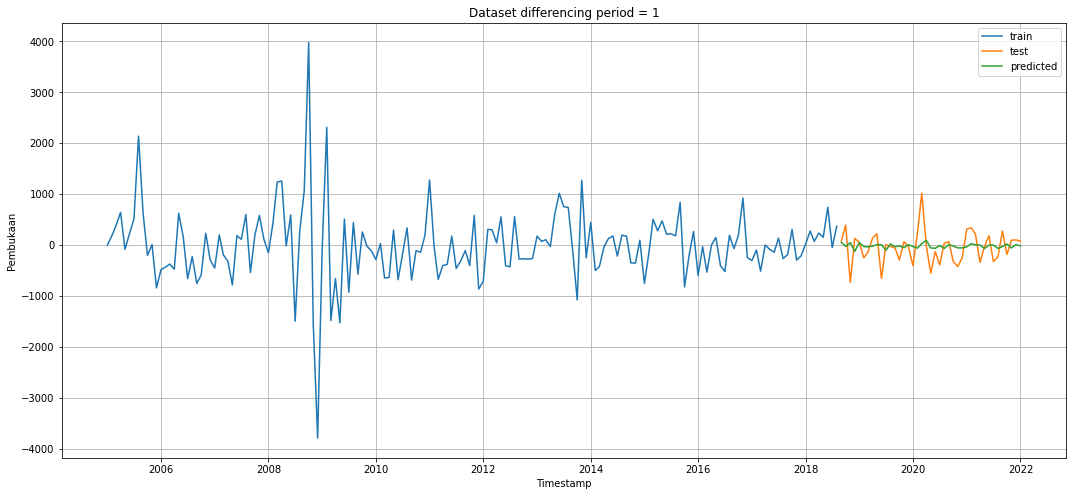

In [ ]:
fig = plt.figure(figsize=(18,8))
plt.plot(train, label='train')
plt.plot(y_true, label='test')
plt.plot(y_pred, label='predicted')
plt.xlabel("Timestamp")
plt.ylabel("Pembukaan")
plt.title("Dataset differencing period = 1")
plt.legend()
plt.grid()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

mse = mean_squared_error(y_true["Pembukaan"], y_pred["Pembukaan"])
print(f"MSE: {mse}")

rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

mape = mean_absolute_percentage_error(y_true["Pembukaan"], y_pred["Pembukaan"])
print(f"MAPE: {mape}")

MSE: 101243.50844696103
RMSE: 318.1878508789439
MAPE: 1.4721995103202374


## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df_rf = differenced_df.copy()

In [ ]:
df_rf['months'] = [x.month for x in df_rf.index]
df_rf['years'] = [x.year for x in df_rf.index]
df_rf['day'] = [x.day for x in df_rf.index]

In [ ]:
train, test = train_test_split(df_rf)

In [ ]:
X = np.array([train['day'], train['months'], train['years']]).T
y = train['Pembukaan']

In [ ]:
model_rf = RandomForestRegressor(n_estimators=90)
model_rf.fit(X, y)

RandomForestRegressor(n_estimators=90)

In [ ]:
X_test = np.array([test['day'], test['months'], test['years']]).T
y_test = test['Pembukaan']
preds = model_rf.predict(X_test)

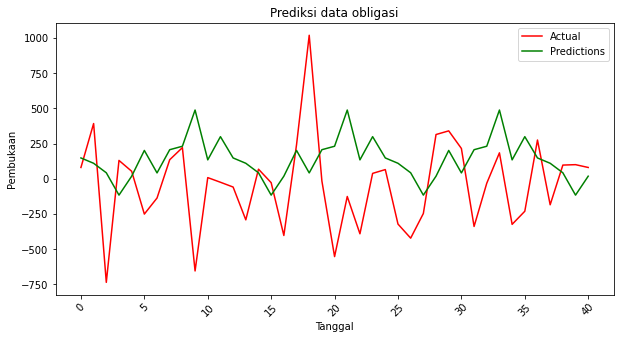

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test.values, color = "red", label='Actual')
plt.ylabel('Pembukaan')
plt.xlabel('Tanggal')
plt.xticks(rotation=45)
plt.title("Prediksi data obligasi")
plt.plot(preds, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [ ]:
rf_eval = mean_squared_error(y_test.values, preds)
print("MSE: ",rf_eval)

rf_eval = np.sqrt(mean_squared_error(y_test.values, preds))
print("RMSE: ",rf_eval)

MSE:  166364.49971996387
RMSE:  407.8780451556125


## LSTM

In [ ]:
def sampling(sequence, n_steps):

  X, Y = list(), list()
  for i in range(len(sequence)):
    sam = i + n_steps
    if sam > len(sequence)-1:
      break

    x, y = sequence[i:sam], sequence[sam]
    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_steps = 1

In [ ]:
train,test = train_test_split(df)

In [ ]:
X, Y = sampling(train['Pembukaan'].tolist(), n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(500, activation='relu', input_shape=(n_steps,1)))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer='adam', loss='mse')

In [ ]:
model_LSTM.fit(X, Y, epochs=200, verbose=0)

In [ ]:
X_test, Y_test = sampling(test['Pembukaan'].tolist(), n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
ypred = model_LSTM.predict(X_test, verbose=0)

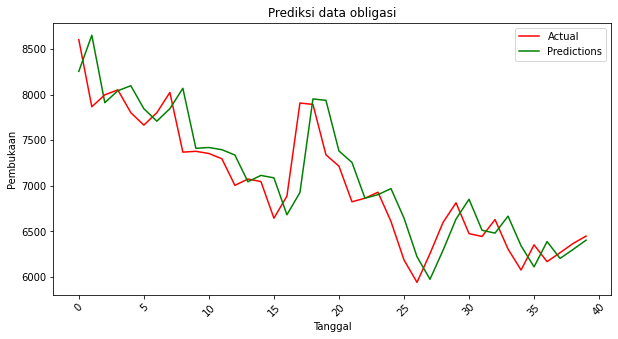

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Y_test, color = "red", label='Actual')
plt.ylabel('Pembukaan')
plt.xlabel('Tanggal')
plt.xticks(rotation=45)
plt.title("Prediksi data obligasi")
plt.plot(ypred, color='green', label = 'Predictions')
plt.legend()
plt.show()

In [ ]:
lstm_eval = mean_squared_error(Y_test, ypred)
print("MSE: ",lstm_eval)

lstm_eval = np.sqrt(mean_squared_error(Y_test, ypred))
print("RMSE: ",lstm_eval)

MSE:  110104.06575837135
RMSE:  331.819326981373
